Import libraries to use later

In [1]:
suppressPackageStartupMessages(library('caret'))
suppressPackageStartupMessages(library('mlbench'))
suppressPackageStartupMessages(library(plyr))

In [2]:
setwd("/Users/naveenmirapuri/Downloads/")

## Reading in Data

Read in Chiefs PFF data rankings from the past two seasons.

'Time' refers to the time of day of the game on a scale of 1.0(early afternoon) to 3.0(evening)

'Result' refers to the point differential of the game, with a line of 'Chiefs -3.5' (Over is a win by more than 3. Under is a loss by 3 or less or a win.) 

In [3]:
df <- read.csv(file='Chiefs19_20_edited.csv')
head(df)

,Time,Result,PA,PASS,PBLK,RECV,RUN,RBLK,RDEF,TACK,PRSH,COV,SPEC
,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,3.0,O,20,67.7,70.9,77.4,71.5,64.2,31.8,29.8,59.7,49.4,67.7
2,2.0,U,20,78.8,62.7,66.4,73.5,65.1,59.3,39.3,68.6,56.3,44.5
3,3.0,O,20,91.5,84.5,74.3,52.3,56.9,30.9,51.0,63.6,69.3,65.4
4,3.0,O,10,44.5,78.0,66.2,57.6,69.2,69.7,75.8,58.3,64.4,61.1
5,1.0,U,40,84.1,71.5,72.7,55.2,59.8,60.0,59.9,62.4,47.2,55.0
6,2.5,O,17,68.6,72.5,60.2,76.0,79.5,75.5,68.6,64.6,61.7,60.5


Remove the 'Points Allowed' metric, as it isn't specific enough and will otherwise dominate the model

In [4]:
drops <- c("PA")
df <- df[ , !(names(df) %in% drops)]
head(df)

,Time,Result,PASS,PBLK,RECV,RUN,RBLK,RDEF,TACK,PRSH,COV,SPEC
,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,3.0,O,67.7,70.9,77.4,71.5,64.2,31.8,29.8,59.7,49.4,67.7
2,2.0,U,78.8,62.7,66.4,73.5,65.1,59.3,39.3,68.6,56.3,44.5
3,3.0,O,91.5,84.5,74.3,52.3,56.9,30.9,51.0,63.6,69.3,65.4
4,3.0,O,44.5,78.0,66.2,57.6,69.2,69.7,75.8,58.3,64.4,61.1
5,1.0,U,84.1,71.5,72.7,55.2,59.8,60.0,59.9,62.4,47.2,55.0
6,2.5,O,68.6,72.5,60.2,76.0,79.5,75.5,68.6,64.6,61.7,60.5


Replace the 'O' and 'U' with 1 and 0 to make the column numeric

In [5]:
df$Result <- sub("O", 1, df$Result)
df$Result <- sub("U", 0, df$Result)
df$Result <- as.numeric(df$Result)
df$Result

[1] 1 0 1 1 0 1 1 1 0 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1

In [6]:
head(df)

,Time,Result,PASS,PBLK,RECV,RUN,RBLK,RDEF,TACK,PRSH,COV,SPEC
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,3.0,1,67.7,70.9,77.4,71.5,64.2,31.8,29.8,59.7,49.4,67.7
2,2.0,0,78.8,62.7,66.4,73.5,65.1,59.3,39.3,68.6,56.3,44.5
3,3.0,1,91.5,84.5,74.3,52.3,56.9,30.9,51.0,63.6,69.3,65.4
4,3.0,1,44.5,78.0,66.2,57.6,69.2,69.7,75.8,58.3,64.4,61.1
5,1.0,0,84.1,71.5,72.7,55.2,59.8,60.0,59.9,62.4,47.2,55.0
6,2.5,1,68.6,72.5,60.2,76.0,79.5,75.5,68.6,64.6,61.7,60.5


### Check/Remove Correlated Data

We will now check for any correlated categories, which should be removed as standard practice to avoid double counting which can skew the model

In [7]:
corrMatrix <- cor(df)  # generates correlation matrix from numeric data.
corrMatrix

,Time,Result,PASS,PBLK,RECV,RUN,RBLK,RDEF,TACK,PRSH,COV,SPEC
Time,1.000000000,0.22177821,-0.008020886,-0.3631432660,-0.07487200,-0.040713012,0.2022834569,-0.24662146,-0.112841852,-0.117332787,0.018195691,0.01340443
Result,0.221778211,1.00000000,0.175296087,0.4380372316,-0.13360991,-0.046009545,0.0395247824,0.03588837,-0.019442051,-0.226706683,0.358260902,0.14470148
PASS,-0.008020886,0.17529609,1.000000000,0.1457058972,0.32823377,-0.089203176,-0.0983874762,-0.15985691,-0.145515914,0.011478485,0.100327343,-0.24543486
PBLK,-0.363143266,0.43803723,0.145705897,1.0000000000,0.14412863,-0.094428136,-0.0002999483,0.02569770,0.038422175,0.078856749,0.108429358,-0.01640191
RECV,-0.074872000,-0.13360991,0.328233766,0.1441286260,1.00000000,-0.074116037,-0.1833448951,-0.03690125,0.060738044,0.418398288,-0.235618951,-0.18681043
RUN,-0.040713012,-0.04600954,-0.089203176,-0.0944281362,-0.07411604,1.000000000,0.4822905185,0.05495785,-0.086825837,0.039588002,0.005782708,0.28679744
RBLK,0.202283457,0.03952478,-0.098387476,-0.0002999483,-0.18334490,0.482290519,1.0000000000,-0.33841943,-0.179208347,-0.007772737,-0.091647881,0.03627559
RDEF,-0.246621460,0.03588837,-0.159856906,0.0256976989,-0.03690125,0.054957846,-0.3384194280,1.00000000,0.430119089,0.059255251,-0.054066727,0.03895413
TACK,-0.112841852,-0.01944205,-0.145515914,0.0384221745,0.06073804,-0.086825837,-0.1792083472,0.43011909,1.000000000,0.009375633,0.350739317,0.02396388
PRSH,-0.117332787,-0.22670668,0.011478485,0.0788567493,0.41839829,0.039588002,-0.0077727370,0.05925525,0.009375633,1.000000000,-0.309232683,-0.21545410


Identify and remove any correlated data with a pearson correlation coefficient above 0.75

In [8]:
highCorrIndex <- findCorrelation(corrMatrix, cutoff=0.75) # returns the indexes of highly-correlated columns
corrColNames <- colnames(corrMatrix)[highCorrIndex]       # retrieves the column names from the indecies
corrColNames                                              # displays the column names to be removed

character(0)

## Use SMOTE library to fix skew/minimal data

There are two main issues with the dataset:

1. The Chiefs rarely lose, so this creates an imbalance in the training data where 'Over' is twice as represented as 'Under'. To fix this, we will use SMOTE to generate more 'Under' cases.

2. Over the last two seasons there are only 35 useable games that accurately estimate the Chiefs, so SMOTE will help extrapolate  hypothetical results to increase the dataset size, and thus accuracy of the model

Below we will see the initial count of Over and Under results

In [9]:
Result <- df$Result
sum(Result == 1)

[1] 23

In [10]:
sum(Result == 0)

[1] 12

Now we will use SMOTE

In [11]:
df$Result <- as.factor(df$Result)  # this changes Result to a factor, a requirement of SMOTE and of later models

In [12]:
suppressPackageStartupMessages(library(DMwR))                  # library containing SMOTE function
df <- SMOTE(Result ~ ., df, perc.over = 500,perc.under=100) # SMOTE Function, perc used to specify number of O/U that need to be generated

In [13]:
Result <- df$Result  # we will now save our normalized Result values

We can now see the number of 'Over's and 'Under's in the new data

In [14]:
sum(Result == 1)

[1] 60

In [15]:
sum(Result == 0)

[1] 72

## Neural Net with hyperparam optimization using H2O

We will now feed the data into a basic Neural Net using the h2o library for a quick implemntation. h2o will also allow for a quick hyperparam optimization as well.

In [16]:
# initialize and import supporting packages for h2o
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(h2o))
h2o.init()


H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    /var/folders/q_/x63jnvxs4r72xyfgkgfvlgc80000gn/T//RtmpJsracE/filed82f385a2aef/h2o_naveenmirapuri_started_from_r.out
    /var/folders/q_/x63jnvxs4r72xyfgkgfvlgc80000gn/T//RtmpJsracE/filed82f27b8cdd0/h2o_naveenmirapuri_started_from_r.err


Starting H2O JVM and connecting: ... Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         3 seconds 294 milliseconds 
    H2O cluster timezone:       America/Los_Angeles 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.32.0.3 
    H2O cluster version age:    25 days  
    H2O cluster name:           H2O_started_from_R_naveenmirapuri_qgr694 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   3.56 GB 
    H2O cluster total cores:    4 
    H2O cluster allowed cores:  4 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port

In [17]:
# we will have to convert our df to an h2o-compatible frame
dfH2O <- as.h2o(df)
dfH2O['Result'] = as.factor(dfH2O['Result'])

  |======================================================================| 100%


In [18]:
dfH2O   # returns the dimensions of the dataframe to get a better idea before modeling

  Time Result PASS PBLK RECV  RUN RBLK RDEF TACK PRSH  COV SPEC
1    3      1 91.5 84.5 74.3 52.3 56.9 30.9 51.0 63.6 69.3 65.4
2    3      1 91.5 84.5 74.3 52.3 56.9 30.9 51.0 63.6 69.3 65.4
3    1      1 67.9 76.1 63.2 58.1 56.7 66.6 70.9 63.9 49.9 57.6
4    1      1 71.8 74.4 74.1 57.8 54.3 69.3 62.4 70.5 58.4 67.5
5    1      1 76.9 81.4 67.6 58.1 70.0 28.9 40.6 55.7 63.3 56.7
6    2      1 79.9 84.5 80.7 52.0 53.4 55.8 63.4 75.8 65.4 51.2

[132 rows x 12 columns] 

We will also have to split the dataframe now into train (60%), validation (20%), and a final test dataset (20%)

In [19]:
split <- h2o.splitFrame(dfH2O, ratios = c(0.6,0.2), seed = 1234)
train <- split[[1]]
valid <- split[[2]]
test <- split[[3]]

We will set our response and input variables

In [20]:
response <- "Result"
predictors <- setdiff(names(df), response)
predictors # displays all of the variables we will use to predict attrition

[1] "Time" "PASS" "PBLK" "RECV" "RUN"  "RBLK" "RDEF" "TACK" "PRSH" "COV" 
[11] "SPEC"

#### These are the various hyperparameters we will test different combinations of, note that some may not converge

In [21]:
hyper_params <- list(activation = c("Rectifier", "Maxout", "Tanh", "RectifierWithDropout", "MaxoutWithDropout", "TanhWithDropout"), 
                     hidden = list(c(50, 50, 50, 50), c(200, 200), c(200, 200, 200), c(200, 200, 200, 200)), 
                     epochs = c(50, 100, 200), 
                     l1 = c(0, 0.00001, 0.0001), 
                     l2 = c(0, 0.00001, 0.0001), 
                     adaptive_rate = c(TRUE, FALSE), 
                     rate = c(0, 0.1, 0.005, 0.001), 
                     rate_annealing = c(1e-8, 1e-7, 1e-6), 
                     rho = c(0.9, 0.95, 0.99, 0.999), 
                     epsilon = c(1e-10, 1e-8, 1e-6, 1e-4), 
                     momentum_start = c(0, 0.5),
                     momentum_stable = c(0.99, 0.5, 0), 
                     input_dropout_ratio = c(0, 0.1, 0.2)
                     )

This is the criteria we will use to search for the best model

In [22]:
search_criteria <- list(strategy = "RandomDiscrete",
                        max_runtime_secs = 10*3600,
                        max_models = 100,
                        stopping_metric = "AUC", 
                        stopping_tolerance = 0.00001, 
                        stopping_rounds = 5, 
                        seed = 1234
                        )

In [23]:
# grid of models with different parameters
models_dl <- h2o.grid(algorithm = "deeplearning", grid_id = "grd_dl", x = predictors, y = "Result",
                      training_frame = train, validation_frame = valid, nfolds = 0, hyper_params = hyper_params,
                      search_criteria = search_criteria, stopping_metric = "AUC", stopping_tolerance = 1e-3, 
                      stopping_rounds = 2, seed = 1234)

  |======================================================================| 100%


Warning message in h2o.getGrid(grid_id = grid_id):
“Some models were not built due to a failure, for more details run `summary(grid_object, show_stack_traces = TRUE)`”


In [24]:
# now we will extract the best model
models_dl_sort <- h2o.getGrid(grid_id = "grd_dl", sort_by = "auc", decreasing = TRUE)
models_dl_best <- h2o.getModel(models_dl_sort@model_ids[[1]])

Warning message in h2o.getGrid(grid_id = "grd_dl", sort_by = "auc", decreasing = TRUE):
“Some models were not built due to a failure, for more details run `summary(grid_object, show_stack_traces = TRUE)`”


In [25]:
# Gets the AUC metric for the best neural network model
models_dl_best@model$validation_metrics@metrics$AUC

[1] 1

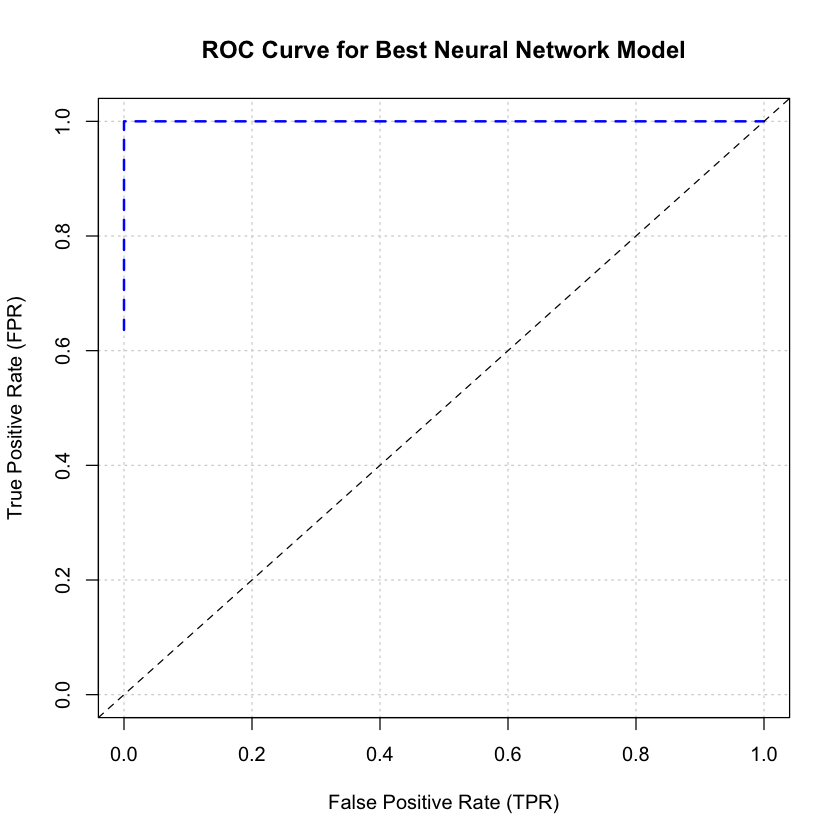

In [26]:
# Creates the ROC curve
perf_dl_best <- h2o.performance(models_dl_best, valid)
plot(perf_dl_best, type="roc", main="ROC Curve for Best Neural Network Model")

# We can now extract the most important variables from the optimized neural net

In [27]:
head(as.data.frame(h2o.varimp(models_dl_best)))

,variable,relative_importance,scaled_importance,percentage
,<chr>,<dbl>,<dbl>,<dbl>
1,RDEF,1.0000000,1.0000000,0.11670557
2,RBLK,0.9589757,0.9589757,0.11191780
3,TACK,0.9122345,0.9122345,0.10646285
4,RUN,0.7746527,0.7746527,0.09040629
5,PRSH,0.7678940,0.7678940,0.08961751
6,RECV,0.7484308,0.7484308,0.08734604


Other imp. metrics below

In [29]:
h2o.performance(models_dl_best, test)

H2OBinomialMetrics: deeplearning

MSE:  0.1101832
RMSE:  0.3319386
LogLoss:  0.6425287
Mean Per-Class Error:  0
AUC:  1
AUCPR:  1
Gini:  1

Confusion Matrix (vertical: actual; across: predicted) for F1-optimal threshold:
        0  1    Error   Rate
0      10  0 0.000000  =0/10
1       0 17 0.000000  =0/17
Totals 10 17 0.000000  =0/27

Maximum Metrics: Maximum metrics at their respective thresholds
                        metric threshold     value idx
1                       max f1  0.001806  1.000000   2
2                       max f2  0.001806  1.000000   2
3                 max f0point5  0.001806  1.000000   2
4                 max accuracy  0.001806  1.000000   2
5                max precision  1.000000  1.000000   0
6                   max recall  0.001806  1.000000   2
7              max specificity  1.000000  1.000000   0
8             max absolute_mcc  0.001806  1.000000   2
9   max min_per_class_accuracy  0.001806  1.000000   2
10 max mean_per_class_accuracy  0.001806  1.0000

In [30]:
h2o.shutdown()

Are you sure you want to shutdown the H2O instance running at http://localhost:54321/ (Y/N)? Y
